# This notebook contains the code which prepares training and test datasets for a model trained with the most frequent 'adj+noun' bigrams, 5-grams of POS combinations, BOW, TF-IDF, seq2seq embedding technique, as well as trains and evaluates this model

## Connect the notebook to MyDrive




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import all necessary libraries

In [5]:
# Standard python libraries for data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NLP packages for text processing
from spacy.lang.en import English
import spacy
from collections import Counter
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.util import ngrams
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

# Custom module
import sys
sys.path.insert(0,'/content/drive/MyDrive/python_project/code')
from models import InferSent

# Libraries to build, train, evaluate, and save an ML model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# from scipy.sparse.csr_matrix import toarray
import pickle
import torch
import locale

import warnings
warnings.filterwarnings('ignore')

In [6]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


## Initialize nlp instance and download necessary resources


To be able to use English language models for processing textual data we might need to download them first. <br>
There was no difference in the accuracy of the model trained on features extracted using a small English language model and the accuracy of the model trained on features extracted using a transformer moel. Therefore, we used the small English language model to use less computing power.
To train the dummy model I used a small statistical model with a 12MB size.
To download the small model you need to run the following command in the code cell: `!python -m spacy download en_core_web_sm`

In [7]:
nlp = English()
nlp = spacy.load('en_core_web_sm') # smaller model

## Initialize NLTK instances

In [8]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Load train and test datasets


In [9]:
# Import train dataset into pandas DataFrame
train_df = pd.read_csv("drive/MyDrive/python_project/data/train_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(train_df.head())

# Import test dataset into pandas DataFrame
test_df = pd.read_csv("drive/MyDrive/python_project/data/test_df.csv")
# Print first 5 rows to see if everything is imported correctly and data is shuffled as we did it at the end of the data-preprocessing notebook
print(test_df.head())

                                            dialogue     name
0   I’ll say it looks good. It’s in my proprietar...  Sheldon
1   Wait, wait, wait. When did you send my mom no...  Leonard
2            I never had a beer with my dad, either.   Howard
3                      My thank you was not sincere.  Sheldon
4   I’m calling to invite you to a spontaneous da...  Sheldon
                                            dialogue     name
0                      Yeah, that’s when it started.  Leonard
1   A million dollars? God, it’s like my nuts jus...   Howard
2   Dinner’s almost ready. If you like meatloaf, ...   Howard
3   Well, Leonard, I think it’s high time you and...  Sheldon
4              All right. It is a comfortable chair.  Sheldon


## Feature engineering

## Get top 10 'ADJ+NOUN' bigrams per character

In [10]:
# Create a dictionary to store bigram frequencies per name
bigram_freq_per_name = {}

# Iterate over each name in the DataFrame
for name in train_df['name'].unique():
    # Get the dialogues for the current name
    dialogues = train_df.loc[train_df['name'] == name, 'dialogue']

    # Tokenize, lemmatize, and extract adjective + noun bigrams
    all_bigrams = []
    for dialogue in dialogues:
        # Remove punctuation using regex
        dialogue = re.sub(r'[^\w\s]', '', str(dialogue))

        doc = nlp(dialogue.lower())  # Make tokens lowercase
        bigrams = [
            f"{token.lemma_} {token2.lemma_}"
            for token, token2 in zip(doc, doc[1:])
            if token.pos_ == 'ADJ' and token2.pos_ == 'NOUN'
            and token.lemma_.lower() not in STOP_WORDS and token2.lemma_.lower() not in STOP_WORDS
        ]
        all_bigrams.extend(bigrams)

    # Calculate the bigram frequencies
    bigram_freq = Counter(all_bigrams)

    # Store the bigram frequencies for the current name
    bigram_freq_per_name[name] = bigram_freq.most_common(10)  # Change the number to get more or fewer common bigrams

# Print the top 10 'adjective' + 'noun' bigrams per name
for name, freq_bigrams in bigram_freq_per_name.items():
    print(f"Top 10 'adjective' + 'noun' bigrams for {name}:")
    for bigram, freq in freq_bigrams:
        print(f"- {bigram}: {freq}")
    print()

Top 10 'adjective' + 'noun' bigrams for Sheldon:
- comic book: 23
- good night: 16
- amy knock: 9
- good friend: 8
- good thing: 7
- wesley crusher: 7
- hot dog: 6
- good morning: 6
- eidetic memory: 5
- good idea: 5

Top 10 'adjective' + 'noun' bigrams for Leonard:
- comic book: 12
- good night: 12
- big deal: 10
- okay let: 7
- little bit: 7
- long time: 6
- good friend: 6
- good time: 6
- good thing: 5
- good luck: 5

Top 10 'adjective' + 'noun' bigrams for Howard:
- international space: 12
- good friend: 11
- comic book: 11
- grown man: 9
- big deal: 6
- good idea: 6
- good news: 6
- fine let: 5
- okay let: 4
- hot dog: 4

Top 10 'adjective' + 'noun' bigrams for Penny:
- good night: 12
- big deal: 11
- soft kitty: 10
- high school: 10
- comic book: 7
- good friend: 7
- warm kitty: 7
- little ball: 6
- right let: 6
- pharmaceutical sale: 5



## Get unique 'ADJ+NOUN' bigrams

In [11]:
# Get all the values of the bigram_freq_per_name dictionary which are tuple of 'adj+noun' bigrams and their frequencies
adj_noun_freq_list = bigram_freq_per_name.values()
# bigram_freq_per_name is the list of lists of 'adj+noun' bigrams + frequency tuples
# To get only 'add+noun' bigrams without frequencies we need to iterate through the list of lists of 'add+noun' bigrams + frequency tuples and then through lists of 'adj+noun' bigrams + frequency tuples and get the first element of the tuple
# For this we used a list comprehension
freq_adj_noun = [adj_noun_freq[0] for adj_noun_freqs in adj_noun_freq_list for adj_noun_freq in adj_noun_freqs]
# To get only unique 'adj+noun' bigrams we cast the list of 'adj+noun' bigrams into a set and then cast it back to a list
unique_freq_adj_nouns = list(set(freq_adj_noun))
# Print the list and length of unique 'adj+noun' bigrams
print(unique_freq_adj_nouns)
print(len(unique_freq_adj_nouns))

['little ball', 'right let', 'good news', 'good luck', 'comic book', 'pharmaceutical sale', 'good night', 'big deal', 'warm kitty', 'high school', 'amy knock', 'good idea', 'hot dog', 'long time', 'good morning', 'wesley crusher', 'eidetic memory', 'good time', 'soft kitty', 'little bit', 'grown man', 'good friend', 'okay let', 'fine let', 'good thing', 'international space']
26


## Get 5-grams of POS combinations per character

In [12]:
# Create a dictionary to store 5-grams of POS combinations frequencies per name
pos_grams_freq_per_name = {}

# Iterate over each name in the DataFrame
for name in train_df['name'].unique():
    # Get the dialogues for the current name
    dialogues = train_df.loc[train_df['name'] == name, 'dialogue']

    # Tokenize, lemmatize, and extract adjective + noun bigrams
    all_pos_grams = []
    for dialogue in dialogues:
        tokens = nltk.word_tokenize(str(dialogue))
        tokens = [token for token in tokens if token not in string.punctuation]
        pos_tokens_tags = nltk.pos_tag(tokens)
        pos_tags = []
        for pos in pos_tokens_tags:
            pos_tags.append(pos[1])
        pos_grams = ngrams(pos_tags, 5)
        pos_grams_list = [" ".join(map(str, gram)) for gram in pos_grams]
        all_pos_grams.extend(pos_grams_list)

    # Calculate the bigram frequencies
    pos_grams_freq = Counter(all_pos_grams)

    # Store the bigram frequencies for the current name
    pos_grams_freq_per_name[name] = pos_grams_freq.most_common(10)  # Change the number to get more or fewer common bigrams

# Print the top 10 'adjective' + 'noun' bigrams per name
for name, freq_pos_bigrams in pos_grams_freq_per_name.items():
    print(f"Top 10 5-grams of POS combinations for {name}:")
    for pos_gram, freq in freq_pos_bigrams:
        print(f"- {pos_gram}: {freq}")
    print()

Top 10 5-grams of POS combinations for Sheldon:
- NNP NNP NNP NNP NNP: 162
- NN IN DT JJ NN: 114
- PRP VBP JJ NN VBP: 104
- DT NN IN DT NN: 102
- JJ NN IN DT NN: 87
- DT JJ NN IN DT: 72
- PRP VBP JJ NN NN: 71
- NN PRP VBP JJ NN: 71
- NN IN DT NN IN: 70
- PRP VBP JJ NN PRP: 65

Top 10 5-grams of POS combinations for Leonard:
- PRP VBP JJ NN VBP: 128
- DT NN IN DT NN: 64
- NN PRP VBP JJ NN: 62
- PRP VBP JJ NNS VBP: 54
- PRP VBP JJ NN TO: 53
- NNP PRP VBP JJ NN: 52
- IN PRP VBP JJ NN: 51
- PRP VBP JJ NN IN: 51
- PRP VBP JJ NN PRP: 50
- PRP VBP RB VBG TO: 48

Top 10 5-grams of POS combinations for Howard:
- PRP VBP JJ NN VBP: 117
- DT NN IN DT NN: 70
- PRP VBP JJ NNS VBP: 70
- PRP VBP JJ NN PRP: 62
- NN PRP VBP JJ NN: 56
- PRP VBP JJ NN TO: 55
- NN IN DT JJ NN: 53
- IN PRP VBP JJ NN: 51
- PRP VBP JJ NN NN: 50
- VBP JJ NN TO VB: 47

Top 10 5-grams of POS combinations for Penny:
- PRP VBP JJ NN VBP: 119
- NN PRP VBP JJ NN: 73
- PRP VBP JJ NN TO: 67
- NNP PRP VBP JJ NN: 58
- VBP JJ NN TO VB: 

## Get unique 5-grams of POS combinations

In [13]:
# Get all the values of the pos_grams_freq_per_name dictionary which are tuple of 5-grams of POS combinations and their frequencies
pos_grams_freq_list = pos_grams_freq_per_name.values()
# pos_grams_freq_per_name is the list of lists of 5-grams of POS combinations + frequency tuples
# To get only 5-grams of POS combinations without frequencies we need to iterate through the list of lists of 5-grams of POS combinations + frequency tuples and then through lists of 5-grams of POS combinations + frequency tuples and get the first element of the tuple
# For this we used a list comprehension
unique_freq_pos_grams = [pos_gram_freq[0] for pos_grams_freqs in pos_grams_freq_list for pos_gram_freq in pos_grams_freqs]
# To get only unique 5-grams of POS combinations we cast the list of 5-grams of POS combinations into a set and then cast it back to a list
unique_freq_pos_grams = list(set(unique_freq_pos_grams))
# Print the list and length of unique 5-grams of POS combinations
print(unique_freq_pos_grams)
print(len(unique_freq_pos_grams))

['PRP VBP JJ NN IN', 'NN IN DT JJ NN', 'RB PRP VBP JJ NN', 'PRP VBP JJ NN TO', 'NNP PRP VBP JJ NN', 'PRP VBP JJ NN VBP', 'VBP JJ NN TO VB', 'PRP VBP JJ NNS VBP', 'NNP NNP NNP NNP NNP', 'DT NN IN DT NN', 'PRP VBP JJ NN PRP', 'DT JJ NN IN DT', 'NN PRP VBP JJ NN', 'JJ NN IN DT NN', 'PRP VBP JJ NN NN', 'IN PRP VBP JJ NN', 'PRP VBP RB VBG TO', 'NN IN DT NN IN']
18


### Download and unzip GloVe model

In [14]:
!curl -Lo drive/MyDrive/python_project/GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip drive/MyDrive/python_project/GloVe/glove.840B.300d.zip -d drive/MyDrive/python_project/GloVe/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   353    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2075M  100 2075M    0     0  4625k      0  0:07:39  0:07:39 --:--:-- 5187k
Archive:  drive/MyDrive/python_project/GloVe/glove.840B.300d.zip
  inflating: drive/MyDrive/python_project/GloVe/glove.840B.300d.txt  


### Initialize InfertSent model


In [16]:
# Initialize the InterSent model
model_version = 1
MODEL_PATH = f"drive/MyDrive/python_project/code/encoder/infersent{model_version}.pkl"
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

# Select GPU in the Edit -> Notebook Settings
# model = model.cuda()

# Use GloVe embedding
W2V_PATH = 'drive/MyDrive/python_project/GloVe/glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


## Prepare train and test datasets for the model to be trained with 5-grams of POS combination technique

In [17]:
# Get a list of dialogues and names from the train dataset
train_dialogues = train_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
train_names = train_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(train_dialogues[:5])
print(train_names[:5])

# Get a list of dialogues and names from the test dataset
test_dialogues = test_df['dialogue'].astype(str).apply(lambda x: x.lower()).to_list()
test_names = test_df['name'].astype(str).apply(lambda x: x.lower()).to_list()
print(test_dialogues[:5])
print(test_names[:5])

[' i’ll say it looks good. it’s in my proprietary font, shelvetica.', ' wait, wait, wait. when did you send my mom notes on a paper?', ' i never had a beer with my dad, either.', ' my thank you was not sincere.', ' i’m calling to invite you to a spontaneous date night tomorrow evening.']
['sheldon', 'leonard', 'howard', 'sheldon', 'sheldon']
[' yeah, that’s when it started.', ' a million dollars? god, it’s like my nuts just kicked me in the nuts. that’s it, i got to start earning more money right now.', ' dinner’s almost ready. if you like meatloaf, i’m sure you’ll like its cousin, bowl of meat.', ' well, leonard, i think it’s high time you and i address the tweepadock in the room.', ' all right. it is a comfortable chair.']
['leonard', 'howard', 'howard', 'sheldon', 'sheldon']


### Prepare "ADJ+NOUN' bigrams features

In [18]:
# Get train numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
train_adj_noun_features = np.zeros((len(train_dialogues), len(unique_freq_adj_nouns)))

# Print the shape of this 2d array
print(train_adj_noun_features.shape)

# Get test numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
test_adj_noun_features = np.zeros((len(test_dialogues), len(unique_freq_adj_nouns)))

# Print the shape of this 2d array
print(test_adj_noun_features.shape)

(18468, 26)
(4596, 26)


In [19]:
# Initialize a train_doc_dialogues generator
train_doc_dialogues = nlp.pipe(train_dialogues)

# Iterate throguh train_doc_dialogues generator and train_features numpy array
for dialogue, f in zip(train_doc_dialogues, train_adj_noun_features):
    # create a bigrams list of all words in the dialogue
    bigrams_list = []
    for i in range(len(dialogue) - 1):
        if dialogue[i].pos_ == 'ADJ' and dialogue[i+1].pos_ == 'NOUN':
            bigram = f"{dialogue[i].lemma_} {dialogue[i+1].lemma_}"
            bigrams_list.append(bigram)
    # iterate through the list of unique 'adj+noun' bigrams
    for bigram in unique_freq_adj_nouns:
        # if the noun in the tokens list
        if bigram in bigrams_list:
            # get the index number of it
            bigram_id = unique_freq_adj_nouns.index(bigram)
            # replace the value of the feature array at the given index with 1
            f[bigram_id] = 1

In [20]:
# Initialize a test_doc_dialogues generator
test_doc_dialogues = nlp.pipe(test_dialogues)

# Iterate throguh test_doc_dialogues generator and test_features numpy array
for dialogue, f in zip(test_doc_dialogues, test_adj_noun_features):
    # create a bigrams list of all words in the dialogue
    bigrams_list = []
    for i in range(len(dialogue) - 1):
        if dialogue[i].pos_ == 'ADJ' and dialogue[i+1].pos_ == 'NOUN':
            bigram = f"{dialogue[i].lemma_} {dialogue[i+1].lemma_}"
            bigrams_list.append(bigram)
    # iterate through the list of unique 'adj+noun' bigrams
    for bigram in unique_freq_adj_nouns:
        # if the noun in the tokens list
        if bigram in bigrams_list:
            # get the index number of the noun in the unique nouns list
            bigram_id = unique_freq_adj_nouns.index(bigram)
            # replace the value of the feature array at the given index with 1
            f[bigram_id] = 1

### Get 5-grams of POS combination features

In [21]:
# Get train numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
train_pos_features = np.zeros((len(train_dialogues), len(unique_freq_pos_grams)))

# Print the shape of this 2d array
print(train_pos_features.shape)

# Get test numpy array with values as zeros in the shape of train_dialogues length * unique_freq_nouns length
test_pos_features = np.zeros((len(test_dialogues), len(unique_freq_pos_grams)))

# Print the shape of this 2d array
print(test_pos_features.shape)

(18468, 18)
(4596, 18)


Fill in the train_features and test_features with 1 if the 5-grams of POS combination is in the dialogue

In [22]:
# Initialize a train_doc_dialogues generator
train_doc_dialogues = nlp.pipe(train_dialogues)

# Iterate throguh train_doc_dialogues generator and train_features numpy array
for dialogue, f in zip(train_doc_dialogues, train_pos_features):
    # tag POS to each token
    tokens = nltk.word_tokenize(str(dialogue))
    tokens = [token for token in tokens if token not in string.punctuation]
    pos_tokens_tags = nltk.pos_tag(tokens)
    # create a 5-grams of POS combination list from all words in the dialogue
    pos_tags = []
    for pos in pos_tokens_tags:
        pos_tags.append(pos[1])
    pos_grams = ngrams(pos_tags, 5)
    pos_grams_list = [" ".join(map(str, gram)) for gram in pos_grams]
    # iterate through the unique list of 5-grams of POS combinations
    for pos_gram in unique_freq_pos_grams:
        # if the 5-gram of POS combination is in the dialogue
        if pos_gram in pos_grams_list:
            # get the index number of it
            pos_gram_id = unique_freq_pos_grams.index(pos_gram)
            # replace the value of the feature array at the given index with 1
            f[pos_gram_id] = 1

In [23]:
# Initialize a test_doc_dialogues generator
test_doc_dialogues = nlp.pipe(test_dialogues)

# Iterate throguh test_doc_dialogues generator and test_features numpy array
for dialogue, f in zip(test_doc_dialogues, test_pos_features):
    # tag POS to each token
    tokens = nltk.word_tokenize(str(dialogue))
    tokens = [token for token in tokens if token not in string.punctuation]
    pos_tokens_tags = nltk.pos_tag(tokens)
    # create a 5-grams of POS combination list from all words in the dialogue
    pos_tags = []
    for pos in pos_tokens_tags:
        pos_tags.append(pos[1])
    pos_grams = ngrams(pos_tags, 5)
    pos_grams_list = [" ".join(map(str, gram)) for gram in pos_grams]
    # iterate through the unique list of 5-grams of POS combinations
    for pos_gram in pos_grams_list:
        # if the 5-gram of POS combination is in the dialogue
        if pos_gram in unique_freq_pos_grams:
            # get the index number of it
            pos_gram_id = unique_freq_pos_grams.index(pos_gram)
            # replace the value of the feature array at the given index with 1
            f[pos_gram_id] = 1

## Get BOW features

In [24]:
# Create a CountVectorizer to convert dialogues into a matrix of token counts
# get a list of stop words
list_of_stop_words = list(STOP_WORDS)
# initialize CountVectorizer instance with stoo words parameters from scikit-learn
count_vectorizer = CountVectorizer(stop_words=(list_of_stop_words))
# process dialogues from the train dataset
train_bow_features = count_vectorizer.fit_transform(train_dialogues)
# process dialogues from the test dataset
test_bow_features = count_vectorizer.transform(test_dialogues)

## Get TF-IDF features

In [25]:
# Create a TfidfVectorizer to convert dialogues into a matrix of TF-IDF features
# get a list of stop words
list_of_stop_words = list(STOP_WORDS)
# initialize TfidfVectorizer instance with stoo words parameters from scikit-learn
tfidf_vectorizer = TfidfVectorizer(stop_words=(list_of_stop_words))
# process dialogues from the train dataset
train_tfidf_features = tfidf_vectorizer.fit_transform(train_dialogues)
# process dialogues from the test dataset
test_tfidf_features = tfidf_vectorizer.transform(test_dialogues)

## Get seq2seq embedded features

In [26]:
# Get training features
train_seq2seq_features = model.encode(train_dialogues, bsize=128, tokenize=False, verbose=True)
print(f'nb sentences encoded : {len(train_seq2seq_features)}')

# Get testing features
test_seq2seq_features = model.encode(test_dialogues, bsize=128, tokenize=False, verbose=True)
print(f'nb sentences encoded : {len(test_seq2seq_features)}')

Nb words kept : 186686/246560 (75.7%)
Speed : 49.3 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 18468
Nb words kept : 45874/60522 (75.8%)
Speed : 47.8 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 4596


## Combine all features

In [27]:
# Get combined train features
train_features = np.hstack((train_adj_noun_features, train_pos_features,  train_bow_features.toarray(), train_tfidf_features.toarray(), train_seq2seq_features))

# Get combined train features
test_features = np.hstack((test_adj_noun_features, test_pos_features,  test_bow_features.toarray(), test_tfidf_features.toarray(), test_seq2seq_features))

## Train the Logistic Regression model with all features

In [28]:
# Make an instance of the Model from LogisticRegression class
lr_all = LogisticRegression()

# Train the model
lr_all.fit(train_features, train_names)

# Print the labels
print(lr_all.classes_)

# Print parameters of the model
print(lr_all.get_params())

['howard' 'leonard' 'penny' 'sheldon']
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## Save the logistic regression model to be trained with 5-grams of POS combinations technique

In [29]:
with open("drive/MyDrive/python_project/lr_all_features_model.pkl", 'wb') as file:
    pickle.dump(lr_all, file)

## Upload trained model

In [34]:
# Load the model with all features
with open('drive/MyDrive/python_project/lr_all_features_model.pkl', 'rb') as file:
    lr_all = pickle.load(file)

## Get predictions

In [30]:
# Define a funtion that will take the index of the dialogue in the test features and predict the name to whom this dialogue might belong
def getPrediction(model):
    predictions = model.predict(test_features)
    return predictions

## Evaluate the logistic regression model trained with 5-grams POS combinations feature

### Accuracy

In [31]:
# Get prediction of all dialogues
predictions_lr = getPrediction(lr_all)
# Use accuracy_score funtion to calculate the accuracy
accuracy = accuracy_score(test_names, predictions_lr)
# Print the accuracy
print("Accuracy of the model trained with 5-grams of POS combinations feature:", accuracy)

Accuracy of the model trained with 5-grams of POS combinations feature: 0.3962140992167102


### Confusion matrix visualization

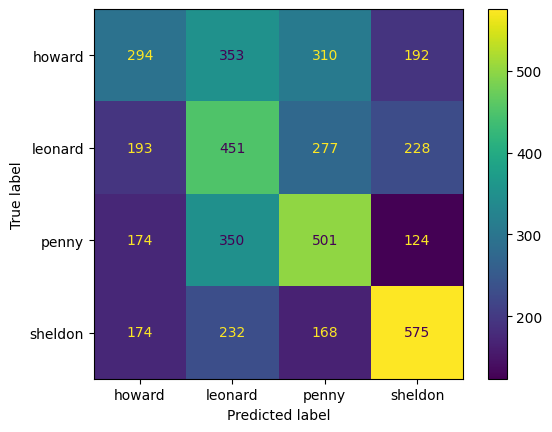

In [32]:
# Get the labels
labels = lr_all.classes_
# Get the confusion matrix
cm = confusion_matrix(test_names, predictions_lr, labels=labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Get classification report

In [33]:
# Print the classification report
print(classification_report(test_names, predictions_lr))

              precision    recall  f1-score   support

      howard       0.35      0.26      0.30      1149
     leonard       0.33      0.39      0.36      1149
       penny       0.40      0.44      0.42      1149
     sheldon       0.51      0.50      0.51      1149

    accuracy                           0.40      4596
   macro avg       0.40      0.40      0.39      4596
weighted avg       0.40      0.40      0.39      4596

